# Assignment


### Part I

Get the silhouette coefficient of the two cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above where cluster number is three. We know that the Iris dataset consists of three different clusters. How do you explain that the silhouette score of the solution with the number of clusters being equal to the correct number of classes is lower than the one where the number of clusters is different from the correct number of classes?


### Part II

In this assignment, you'll be working with the heart disease dataset from the UC Irvine Machine Learning Repository.

Load the dataset from the Thinkful's database. Here's the credentials you can use to connect to the database:

`postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'`

The dataset needs some preprocessing. So, apply the following code before working with the dataset:

`# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]`

`# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)`

`# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)`

Here, X will be your features and in y we hold the labels. If y is equal to 1, then it indicates that the corresponding patient has heart disease and if y is equal to 0, then the patient doesn't have heart disease.

Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?
Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

# Part I

In [2]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [45]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import datasets
from sklearn.metrics import silhouette_score, adjusted_rand_score

from sqlalchemy import create_engine
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [24]:
# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print(silhouette_score(X_std, labels, metric="euclidean"))

0.5817500491982808


<IPython.core.display.Javascript object>

This silhouette score is higher than the 3-cluster solution because, even though there are three true clusters, two of them are not well-separated, so the score goes up when they're lumped together.

# Part II

In [54]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "heartdisease"


engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

heartdisease_df = pd.read_sql_query("select * from heartdisease", con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()


# The dataset needs some preprocessing.
# So, apply the following code before working with the dataset:

# Define the features and the outcome
X = heartdisease_df.iloc[1:, :13]
y = heartdisease_df.iloc[1:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace="?", value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

<IPython.core.display.Javascript object>

In [55]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std, X_pca, test_size=0.5, random_state=13579
)

<IPython.core.display.Javascript object>

In [56]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([(X_half1, X_pcahalf1), (X_half2, X_pcahalf2)]):

    # Put the features into ypred.
    ypred["pca_f1" + "_sample" + str(counter)] = data[1][:, 0]
    ypred["pca_f2" + "_sample" + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred["clust" + str(nclust) + "_sample" + str(counter)] = pred

<IPython.core.display.Javascript object>

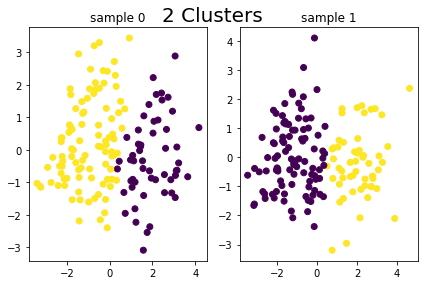

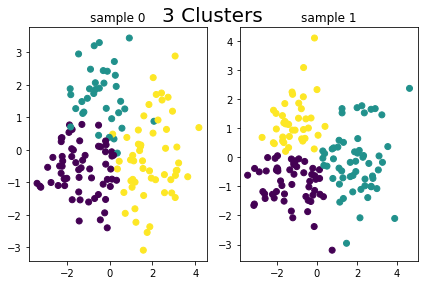

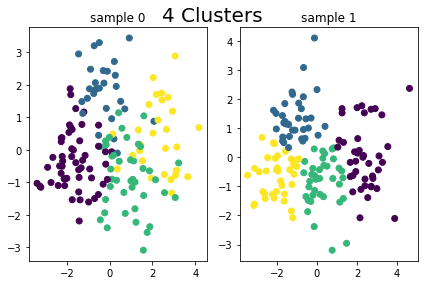

<IPython.core.display.Javascript object>

In [57]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # PCA-created features.
        x_sub = ypred["pca_f1_sample{}".format(i)]
        y_sub = ypred["pca_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print("\n")

I honestly can't tell which is best because they all seem pretty arbitrary in terms of cluster location, but they also seem pretty consistent between samples.

In [65]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([(X_std, X_pca)]):

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred["clust" + str(nclust)] = pred
        print("ARI for " + str(nclust))
        print(adjusted_rand_score(y, pred))
        print("\n")
        print("silhouette for " + str(nclust))
        print(silhouette_score(X_std, pred, metric="euclidean"))
        print("\n")

ARI for 2
0.44545609632673205


silhouette for 2
0.17617692225171439


ARI for 3
0.287255517548566


silhouette for 3
0.12996444713869768


ARI for 4
0.19697359988106525


silhouette for 4
0.13306171223315108




<IPython.core.display.Javascript object>

2 clusters looks like the best m